### Problem 4

As suggested by the Problem 4, the *mtry* parameter in Random Forest plays a role of inexplicit regularization. To investigate this phenomenon and provide supporting evidence, we intend to compare the performance of random forest and bagging to see the effect of randomness induced by *mtry*.

Consider the following model:
$$
\mathcal{D}_n = \{Z_1,\dots, Z_n\}, \ Z_i = (X_i, Y_i), \ X_i = (X_{1,i},\dots,X_{p,i})
$$
$$
Y = f(X) + \epsilon, \ \epsilon_i \overset{\text{i.i.d.}}{\sim}\mathcal{N}(0, \sigma^2)
$$


We shall evaluate the degrees of freedom by 
$$
df(\hat{f}) = \frac{1}{\sigma^2}\sum_{i=1}^n \text{Cov}(\hat{y}_i, y_i)
$$

Higher DOF implies less flexiblity and higher variance. We expect to see: 
for fixed parameter *mtry*, by adding more terminal nodes, we incorporate more DOF, thus making the estimator more sensitive to the data. 

We consider the same linear model in the paper.
$$
Y = X\beta + \epsilon
$$
- Low: n = 100, p = 10, s = 5
- Medium: n = 500, p = 100, s = 5
- High-10: n = 100, p = 1000, s = 10 

For each model, we let *mtry* = $\sqrt{p}, p/3, p$. When *mtry* = $p$, the random forest is essentially bagging.
- p=10: *mtry* = 3, 10
- p = 100: *mtry* = 10, 33, 100
- p = 1000: *mtry* = 32, 333, 1000

Declaration: The author do the numerical experiement in R. I implement this model using Python by myself and use slightly different *mtry* parameter.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from numpy.random import default_rng
rng = default_rng()

In [2]:
class LinearDataGen:
    def __init__(self, n, p, s, rho=0.35, snr=3.52):
        Sigma = np.zeros((p,p))
        for i in range(p):
            for j in range(p):
                Sigma[i, j] = rho**(np.abs(i-j))
        self.X = rng.multivariate_normal(np.zeros(p), Sigma, n)
        self.beta = np.array([1.0*(i < s) for i in range(p)])
        self.var = self.beta.T@Sigma@self.beta/snr
        self.Y = self.X.dot(self.beta) + rng.normal(0, np.sqrt(self.var), n)

In [6]:
def simRF(maxfeatures, maxnodes, n, p, s, snr=3.52, rho=0.35, nrep=500):
    Y_pred = np.zeros((nrep, n))
    Y = np.zeros((nrep, n))
    for i in range(nrep):
        data = LinearDataGen(n, p, s, rho=rho, snr=snr)
        Y[i,:] = data.Y
                      
                      
        model = RandomForestRegressor(max_leaf_nodes=int(maxnodes),
                                      max_features=maxfeatures,
                                      n_estimators=50, 
                                      criterion='squared_error',)
        model.fit(data.X, data.Y)
        Y_pred[i,:] = model.predict(data.X)
        # print(mean_squared_error(Y[i,:], Y_pred[i,:]))
        
    cov_n = np.zeros(n)
    for i in range(n):
        cov_n[i] = np.cov(Y_pred[:,i], Y[:,i])[0][1]
    df = np.sum(cov_n)/data.var
    
    return df

In [7]:
# Low 
n = 100
p = 10
s = 5
mtryList = [3, 10]
maxnodesList = np.ceil(np.linspace(2, 20, 9))

dfs_low = np.zeros((len(mtryList), len(maxnodesList)))
for (i, mtry) in enumerate(mtryList):
    for (j, maxnodes) in enumerate(maxnodesList):
        dfs_low[i, j] = simRF(mtry, maxnodes, n, p, s)

In [ ]:
# Medium
n = 500
p = 100
s = 5
mtryList = [10, 33, 100]
maxnodesList = np.ceil(np.linspace(2, 100, 9))

dfs_med = np.zeros((len(mtryList), len(maxnodesList)))
for (i, mtry) in enumerate(mtryList):
    for (j, maxnodes) in enumerate(maxnodesList):
        dfs_med[i, j] = simRF(mtry, maxnodes, n, p, s)

In [ ]:
# High
n = 100
p = 1000
s = 10
mtryList = [10, 33, 100]
maxnodesList = np.ceil(np.linspace(2, 20, 9))

dfs_high = np.zeros((len(mtryList), len(maxnodesList)))
for (i, mtry) in enumerate(mtryList):
    for (j, maxnodes) in enumerate(maxnodesList):
        dfs_high[i, j] = simRF(mtry, maxnodes, n, p, s)

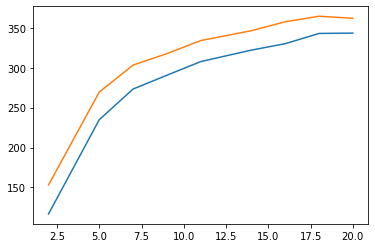

In [16]:
plt.plot(np.ceil(np.linspace(2, 20, 9)), dfs_low.T)
plt.show()

I check my code many many times and also discuss my implementation with my mates. However, it can not generate satisfied results to reproduce the same figure in the paper.
The main reason is that the implementation of random forest in scikit-learn is different from R.
I try to tune the parameter to match default parameter in R. But it is hard to realize.
Good thing is that the trend of the plot is consistent with the paper.